In [126]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
import ast
from scipy.optimize import curve_fit, nnls
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError, pauli_error, depolarizing_error, thermal_relaxation_error)
from qiskit.quantum_info import Pauli, pauli_basis, SuperOp, PTM, Operator

home_folder = os.getcwd()
is_pyquil = "pyquil_program" in home_folder
if is_pyquil and "AutomatedPERTools" in home_folder:
	raise Exception("Both folders?")
i = 0
while not "pauli_lindblad_per" in os.listdir(home_folder):
	home_folder = os.path.dirname(home_folder)
	i+=1
	if i == 50:
		raise Exception("pauli_lindblad_per not found. Please make sure it is in this or a parent folder")
sys.path.append(os.path.join(home_folder, "pauli_lindblad_per"))
import pickle

print(home_folder)

e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools


In [127]:
def decipher_name(namebase):
    i = 0
    dic = dict()
    split_namebase = namebase.split("_")
    #parser.add_argument('--plusone', '-p', help='Takes Neighboring qubits into account', default=False, action='store_true')
    #i, dic["tomography_connections"] = i+1, (split_namebase[i] == "True")
    #parser.add_argument('--sum', '-s', help='Same as -p and turns sumation on over neighboring qubits', default=False, action='store_true')
    i, dic["sum_over_lambda"] = i+1, (split_namebase[i] == "True")
    #if dic["sum_over_lambda"]:
        #dic["tomography_connections"] = True
    #parser.add_argument('--pntsamples', type=int, help='How many samples in PNT? Default: 16', default=16)
    i, dic["pntsamples"] = i+1, int(split_namebase[i])
    #parser.add_argument('--pntsinglesamples', type=int, help='How many single samples in PNT? Default: 100', default=100)
    i, dic["pntsinglesamples"] = i+1, int(split_namebase[i])
    #parser.add_argument('--persamples', type=int, help='How many samples in PER? Default: 100', default=100)
    i, dic["persamples"] = i+1, int(split_namebase[i])
    #parser.add_argument('--shots', type=int, help='How many shots? Default: 1000', default=1000)
    i, dic["shots"] = i+1, int(split_namebase[i])
    #parser.add_argument('--backend', type=str, help='Which backend to use? Default: FakeVigoV2', default="FakeVigoV2")
    from qiskit.providers.fake_provider import GenericBackendV2
    i, num = i+1, int(split_namebase[i])
    coupling_map = [[i,i+1] for i in range(num-1)]+[[i+1,i] for i in range(num-1)]
    backend = GenericBackendV2(num_qubits=num, coupling_map=coupling_map)
    dic["backend"] = backend
    dic["num_qubits"] = num

    #parser.add_argument('--cross', '-c', help='Simulates Cross Talk Noise', default=False, action='store_true')
    i, dic["do_cross_talk_noise"] = i+1, (split_namebase[i] == "True")
    #parser.add_argument('--allqubits', '-a', help='runs over all qubits in the tomography', default=False, action='store_true')
    #i, dic["allqubits"] = i+1, (split_namebase[i] == "True")
    #parser.add_argument('--onlyTomography', help='Only does the tomography and then ends the program', default=False, action='store_true')
    i, dic["onlyTomography"] = i+1, (split_namebase[i] == "True")

    #parser.add_argument('--setqubits', type=int, nargs='+', help='Which qubits to use?: Default: 0123 and transpile')
    i, dic["qubits"]= i+1, ast.literal_eval(split_namebase[i])
    if dic["qubits"] !=  [0,1,2,3]:
        dic["num_qubits"] = backend.num_qubits    
    else:
        dic["num_qubits"] = len(dic["qubits"])
    #if split_namebase[7] == '[0,1,2,3]' and split_namebase[8] == 'and' and split_namebase[9] == 'transpile':
    i, dic["depths"]= i+1, ast.literal_eval(split_namebase[i])
    return dic

In [128]:
# Determine Folders
main_folder_path = "tutorial_notebooks/testrun/server_run_collection".split('/')
main_folder = ""
for segment in main_folder_path:
    main_folder = os.path.join(main_folder, segment)
folders = [f for f in os.listdir(os.path.join(home_folder, main_folder)) if os.path.isdir(os.path.join(os.path.join(home_folder, main_folder), f))]
#filtered_folders = [f for f in folders if "False_16_100_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8]_circuits_make_initial_Circuit_False__generic_backend_4" in f]
i=5

if i == 0:
	filtered_folders = [f for f in folders if decipher_name(f)["num_qubits"] == 4 and decipher_name(f)["depths"] == [2,4,8,16] and decipher_name(f)["pntsinglesamples"] == 100]
	filtered_folders = sorted(filtered_folders, key=lambda item: decipher_name(item)["pntsamples"])
elif i==1:
	filtered_folders = [f for f in folders if decipher_name(f)["num_qubits"] == 4 and decipher_name(f)["depths"] == [2,4,8,16,32] and decipher_name(f)["pntsinglesamples"] == 1000]
	filtered_folders = sorted(filtered_folders, key=lambda item: decipher_name(item)["pntsamples"])
elif i==2:
	filtered_folders = list(reversed([f for f in folders if decipher_name(f)["num_qubits"] == 4 and decipher_name(f)["pntsamples"] == 16 and decipher_name(f)["pntsinglesamples"] == 100]))
elif i==3:
	filtered_folders = list(reversed([f for f in folders if decipher_name(f)["num_qubits"] == 4 and decipher_name(f)["pntsamples"] == 64 and decipher_name(f)["pntsinglesamples"] == 1000]))
elif i==4:
	filtered_folders = [f for f in folders if decipher_name(f)["num_qubits"] == 4 and decipher_name(f)["depths"] == [2,4,8,16] and decipher_name(f)["pntsamples"] == 16]
	filtered_folders = sorted(filtered_folders, key=lambda item: decipher_name(item)["pntsinglesamples"])
elif i==5:
	filtered_folders = [f for f in folders if decipher_name(f)["num_qubits"] == 4 and decipher_name(f)["depths"] == [2,4,8,16,32] and decipher_name(f)["pntsamples"] == 64]
	filtered_folders = sorted(filtered_folders, key=lambda item: decipher_name(item)["pntsinglesamples"])

                    #decipher_name(f)["pntsamples"] == 64 and 
                    #"False_16_100_100_1024_3_False_True_{0, 1}_[2, 4, 8, 16]__CNOT_LAYER1" in f]
#filtered_folders = sorted(filtered_folders, key=lambda item: decipher_name(item)["pntsinglesamples"])
for folder in filtered_folders:
    print(folder)

False_64_10_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8, 16, 32]_circuits_make_initial_Circuit_False__generic_backend_4
False_64_20_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8, 16, 32]_circuits_make_initial_Circuit_False__generic_backend_4
False_64_30_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8, 16, 32]_circuits_make_initial_Circuit_False__generic_backend_4
False_64_40_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8, 16, 32]_circuits_make_initial_Circuit_False__generic_backend_4
False_64_50_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8, 16, 32]_circuits_make_initial_Circuit_False__generic_backend_4
False_64_60_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8, 16, 32]_circuits_make_initial_Circuit_False__generic_backend_4
False_64_70_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8, 16, 32]_circuits_make_initial_Circuit_False__generic_backend_4
False_64_80_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8, 16, 32]_circuits_make_initial_Circuit_False__generic_backend_4
False_64_90_100_1024_4_False_True_{0, 1,

In [129]:
samplesize = {}
for folder in folders:
    samplesize[folder] = len(os.listdir(os.path.join(home_folder,main_folder,folder,"cliff_layer")))
samplesizesorted = sorted(samplesize, key=lambda item: samplesize[item])
minisam = (min(samplesize.values()))
for sam in samplesizesorted:
    if samplesize[sam] <=minisam:
    	print(sam, samplesize[sam])

False_16_200_200_1024_4_False_False_{0, 1, 2, 3}_[2, 4, 8, 16]_circuits_make_initial_Circuit_False__generic_backend_4 1


In [130]:
def separate_gates(layer, weight : int):
	"""This method parses the list of gates in the input layer and returns a Circuit
	consisting only of gates with the desired weight"""

	qc = layer.copy_empty() 
	for inst in layer:
		if inst.weight() == weight:
			qc.add_instruction(inst)
	return qc

folder = filtered_folders[0]
folderpath = os.path.join(os.path.join(home_folder, main_folder),folder)
with open(os.path.join(folderpath, "circuits.pickle"), "rb") as f:
	circuits = pickle.load(f)

with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),filtered_folders[0]), "noise_model.pickle"), "rb") as f:
    (noise_model, twoqubit_error_template, singlequbit_error_template) = pickle.load(f)
#from TrotterExample import get_noise_model, make_initial_Circuit
#(noise_model, twoqubit_error_template, singlequbit_error_template) = get_noise_model()
dic = decipher_name(filtered_folders[0])
backend = dic["backend"]
full_circuit = circuits[0]
sys.path.append(os.path.join(os.path.join(home_folder, "tutorial_notebooks"),"testrun"))
from main import circuit_to_layers
from primitives.circuit import QiskitCircuit

layers = circuit_to_layers(QiskitCircuit(full_circuit))
layer_number = 0
#circuit_layer = layers[layer_number].qc
cliff_layers = list()
for i in range(4):
	if separate_gates(layers[i], 2) not in cliff_layers:
		cliff_layers.append(separate_gates(layers[i], 2))
circuit_layer = cliff_layers[layer_number].qc
for cliff in cliff_layers:
	print(cliff.qc.draw())

              
q_0 -> 0 ──■──
         ┌─┴─┐
q_1 -> 1 ┤ X ├
         └───┘
q_2 -> 2 ──■──
         ┌─┴─┐
q_3 -> 3 ┤ X ├
         └───┘
              
q_0 -> 0 ─────
              
q_1 -> 1 ──■──
         ┌─┴─┐
q_2 -> 2 ┤ X ├
         └───┘
q_3 -> 3 ─────
              


In [131]:
def average_data_error(data_dic_array_array, cliff_layer_array):
	ret = []
	ret_error = []
	ret_list = []
	for layer in cliff_layers:
		data_average = {key: 0 for key in data_dic_array_array[0][0]}
		data_list = {key: [] for key in data_dic_array_array[0][0]}
		data_average_error = {key: 0 for key in data_dic_array_array[0][0]}
		for key in data_average:
			data = []
			for j in range(len(data_dic_array_array)):
				for k in range(len(cliff_layer_array[j])):
					if str(layer) == str(cliff_layer_array[j][k]):
						i = k
						break
				data.append(data_dic_array_array[j][i][key])
				data_list[key].append(data_dic_array_array[j][i][key])
			data_average[key] = sum(data)/len(data)
			data_average_error[key] = np.std(data)
		ret.append(data_average)
		ret_error.append(data_average_error)
		ret_list.append(data_list)
	return (ret, ret_error, ret_list)

# Load Data
from qiskit.quantum_info import Pauli, pauli_basis
coeffs_datas = []
coeffs_error_datas = []
coeffs_individual_datas = []
infidelities_datas = []
infidelities_error_datas = []
infidelities_individual_datas = []
for folder in filtered_folders:
	folderpath = os.path.join(os.path.join(home_folder, main_folder),folder)
	print(os.path.join(folderpath, "coeffs.pickle"))
	coeffs_array = []
	infidelities_array = []
	cliff_layer_array = []
	for file in os.listdir(os.path.join(folderpath, "coeffs")):
		with open(os.path.join(os.path.join(folderpath, "coeffs"), file), "rb") as f:
			#coeffs = pickle.load(f)
			coeffs_array.append(pickle.load(f))
		with open(os.path.join(os.path.join(folderpath, "infidelities"), file), "rb") as f:
			infidelities_array.append(pickle.load(f))
		with open(os.path.join(os.path.join(folderpath, "cliff_layer"), file), "rb") as f:
			cliff_layer_array.append(pickle.load(f))

	coeffs, coeffs_error, coeffs_individual = average_data_error(coeffs_array, cliff_layer_array)
	infidelities, infidelities_error, infidelities_individual = average_data_error(infidelities_array, cliff_layer_array)
	coeffs_datas.append(coeffs)
	coeffs_error_datas.append(coeffs_error)
	coeffs_individual_datas.append(coeffs_individual)
	infidelities_datas.append(infidelities)
	infidelities_error_datas.append(infidelities_error)
	infidelities_individual_datas.append(infidelities_individual)
	#print(coeffs)
	#print(coeffs_error)
	
	#with open(os.path.join(folderpath, "coeffs.pickle"), "rb") as f:
	#	coeffs = pickle.load(f)
	#print(coeffs)
	#with open(os.path.join(folderpath, "infidelities.pickle"), "rb") as f:
	#	infidelities = pickle.load(f)
	#infidelities_datas.append(infidelities)

e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\tutorial_notebooks\testrun\server_run_collection\False_64_10_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8, 16, 32]_circuits_make_initial_Circuit_False__generic_backend_4\coeffs.pickle
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\tutorial_notebooks\testrun\server_run_collection\False_64_20_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8, 16, 32]_circuits_make_initial_Circuit_False__generic_backend_4\coeffs.pickle
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\tutorial_notebooks\testrun\server_run_collection\False_64_30_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8, 16, 32]_circuits_make_initial_Circuit_False__generic_backend_4\coeffs.pickle
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\tutorial_notebooks\testrun\server_run_collection\False_64_40_100_1024_4_False_True_{0, 1, 2, 3}_[2, 4, 8, 16, 32]_circuits_make_initial_Circuit_False__generic_backend_4\coeffs.pickle
e:\OneDrive\Dokument

In [132]:
def make_initial_Circuit(qubits, num_qubits, backend, n):
    from qiskit import transpile, QuantumCircuit
    def trotterLayer(h,J,dt,n):
        trotterLayer = QuantumCircuit(num_qubits)
        trotterLayer.rx(dt*4*h, qubits)
        trotterLayer.cx(*zip(*[(qubits[2*i], qubits[2*i+1]) for i in range(n)]))
        trotterLayer.rz(-4*J*dt, [qubits[2*i+1] for i in range(n)])
        trotterLayer.cx(*zip(*[(qubits[2*i], qubits[2*i+1]) for i in range(n)]))
        trotterLayer.cx(*zip(*[(qubits[2*i+1], qubits[2*i+2]) for i in range(n-1)]))
        trotterLayer.rz(-4*J*dt, [qubits[2*i+2] for i in range(n-1)])
        trotterLayer.cx(*zip(*[(qubits[2*i+1], qubits[2*i+2]) for i in range(n-1)]))
        return trotterLayer

    h = 1
    J = -.15
    dt = .2

    def maketrotterCircuit(s):
        tL = trotterLayer(h, J, dt, n)
        trotterCircuit = QuantumCircuit(num_qubits)
        for i in range(s):
            trotterCircuit = trotterCircuit.compose(tL)
            trotterCircuit.barrier()

        transpiled = transpile(trotterCircuit, backend)
        return transpiled

    return [maketrotterCircuit(i) for i in range(1,15)]

In [133]:
def get_backend(num_qubits):
    from qiskit.providers.fake_provider import GenericBackendV2
    num = num_qubits
    coupling_map = [[i,i+1] for i in range(num-1)]+[[i+1,i] for i in range(num-1)]
    backend = GenericBackendV2(num_qubits=num, coupling_map=coupling_map)
    return backend

In [134]:
def get_index(qc, inst, i=None):
    if i:
        qubit = inst.qubits[i]
        index = -1
        for register in qc.qregs:  # Assuming you're using `QuantumCircuit`
            if qubit in register:
                index = register.index(qubit)
                break
        return index
    else:
        qubits = inst.qubits
        indexes = []
        for qubit in qubits:
            index = -1
            for register in qc.qregs:  # Assuming you're using `QuantumCircuit`
                if qubit in register:
                    index = register.index(qubit)
                    break
            indexes.append(index)
        return indexes

In [135]:
def get_error_for_circuit(circuit, twoqubit_error_template, singlequbit_error_template, num_qubits, used_qubits):
    from qiskit.quantum_info import Pauli
    def mul_Pauli(pauli1, pauli2):
        result = pauli1.compose(pauli2)
        nophase = Pauli((result.z, result.x))
        return nophase
    redirect = {}
    for i, qubit in enumerate(used_qubits):
        redirect[qubit] = i
    identity_string = 'I'*num_qubits
    error_state = {Pauli(identity_string): 1}
    for inst in circuit:
        temp_error_state = {}
        indexes = [redirect[i] for i in get_index(circuit, inst)]
        if inst.operation.name == "cx":
            for og_op in error_state:
                op = og_op
                if og_op[indexes[0]] == 'X' or og_op[indexes[0]] == 'Y':
                    temp_op = Pauli("".join(reversed(identity_string[:indexes[1]] + 'X' + identity_string[indexes[1]+1:])))
                    op = mul_Pauli(temp_op, op)
                if og_op[indexes[1]] == 'Z' or og_op[indexes[1]] == 'Y':
                    temp_op = Pauli("".join(reversed(identity_string[:indexes[0]] + 'Z' + identity_string[indexes[0]+1:])))
                    op = mul_Pauli(temp_op, op)
                temp_error_state[op] = error_state[og_op]
            error_state = temp_error_state
            temp_error_state = {}
        if len(indexes) == 1:
            index = indexes[0]
            for (op, p) in singlequbit_error_template:
                op = Pauli("".join(reversed(identity_string[:index] + str(op)+ identity_string[index+1:])))
                for og_op in error_state:
                    og_p = error_state[og_op]
                    new_op = mul_Pauli(op, og_op)
                    temp_error_state[new_op] = temp_error_state.get(new_op, 0) + p*og_p
        elif len(indexes) == 2:
            for (op, p) in twoqubit_error_template:
                if is_pyquil:
                    op = "".join(reversed(op))
                temp_string = (identity_string[:indexes[0]] + "".join(reversed(str(op)))[0]+ identity_string[indexes[0]+1:])
                op = Pauli("".join(reversed(temp_string[:indexes[1]] + "".join(reversed(str(op)))[1]+ temp_string[indexes[1]+1:])))
                for og_op in error_state:
                    og_p = error_state[og_op]
                    new_op = mul_Pauli(op, og_op)
                    temp_error_state[new_op] = temp_error_state.get(new_op, 0) + p*og_p
        else:
            if inst.operation.name == 'barrier':
                continue
            raise Exception("Too many qubits")
        error_state = temp_error_state
    return [(op, error_state[op]) for op in error_state]

In [136]:
def model_terms(layer, *list):
    return layer._model_terms(list)

In [137]:
def splice_string(string, indexes):
    for index in sorted(indexes):
        index -= sorted(indexes).index(index)
        string = string[:index]+string[index+1:]
    return string

In [138]:
used_qubits = set()
for inst in full_circuit: #look at the commands
    for j in range(len(inst.qubits)): #record which qubits they use
        try:
            for i in get_index(full_circuit, inst, i=j):
                used_qubits.add(i)
        except:
            used_qubits.add(get_index(full_circuit, inst, i=j)) #and save those
print(used_qubits)

{0, 1, 2, 3}


In [139]:
choosen_qubits = [i for i in range(decipher_name(filtered_folders[0])["num_qubits"])]
num_used_qubits = len(used_qubits)
num_qubits = len(choosen_qubits)
choosen_used_qubits = [i for i in range(num_used_qubits)]
groups = []
used_groups = []
for qubit in choosen_qubits:
    groups += [pauli for pauli in pauli_basis(num_qubits) if str(pauli)[::-1][qubit] != 'I' and (splice_string(str(pauli)[::-1], [qubit]) == 'I'*(num_qubits-1))]
for qubit in choosen_used_qubits:
    used_groups += [pauli for pauli in pauli_basis(num_used_qubits) if str(pauli)[::-1][qubit] != 'I' and (splice_string(str(pauli)[::-1], [qubit]) == 'I'*(num_used_qubits-1))]
for qubit1, qubit2 in [i for i in backend.coupling_map]:
    if qubit1 > qubit2:
        print(qubit1, qubit2)
        groups += [pauli for pauli in pauli_basis(num_qubits) if str(pauli)[::-1][choosen_qubits[qubit1]] != 'I' and str(pauli)[::-1][choosen_qubits[qubit2]] != 'I' and (splice_string(str(pauli)[::-1], [choosen_qubits[qubit1], choosen_qubits[qubit2]]) == 'I'*(num_qubits-2))]
        if qubit1 in choosen_used_qubits and qubit2 in choosen_used_qubits:
            used_groups += [pauli for pauli in pauli_basis(num_used_qubits) if str(pauli)[::-1][choosen_qubits[qubit1]] != 'I' and str(pauli)[::-1][choosen_qubits[qubit2]] != 'I' and (splice_string(str(pauli)[::-1], [choosen_qubits[qubit1], choosen_qubits[qubit2]]) == 'I'*(num_used_qubits-2))]
print(groups)
print(used_groups)

1 0
2 1
3 2
[Pauli('IIIX'), Pauli('IIIY'), Pauli('IIIZ'), Pauli('IIXI'), Pauli('IIYI'), Pauli('IIZI'), Pauli('IXII'), Pauli('IYII'), Pauli('IZII'), Pauli('XIII'), Pauli('YIII'), Pauli('ZIII'), Pauli('IIXX'), Pauli('IIXY'), Pauli('IIXZ'), Pauli('IIYX'), Pauli('IIYY'), Pauli('IIYZ'), Pauli('IIZX'), Pauli('IIZY'), Pauli('IIZZ'), Pauli('IXXI'), Pauli('IXYI'), Pauli('IXZI'), Pauli('IYXI'), Pauli('IYYI'), Pauli('IYZI'), Pauli('IZXI'), Pauli('IZYI'), Pauli('IZZI'), Pauli('XXII'), Pauli('XYII'), Pauli('XZII'), Pauli('YXII'), Pauli('YYII'), Pauli('YZII'), Pauli('ZXII'), Pauli('ZYII'), Pauli('ZZII')]
[Pauli('IIIX'), Pauli('IIIY'), Pauli('IIIZ'), Pauli('IIXI'), Pauli('IIYI'), Pauli('IIZI'), Pauli('IXII'), Pauli('IYII'), Pauli('IZII'), Pauli('XIII'), Pauli('YIII'), Pauli('ZIII'), Pauli('IIXX'), Pauli('IIXY'), Pauli('IIXZ'), Pauli('IIYX'), Pauli('IIYY'), Pauli('IIYZ'), Pauli('IIZX'), Pauli('IIZY'), Pauli('IIZZ'), Pauli('IXXI'), Pauli('IXYI'), Pauli('IXZI'), Pauli('IYXI'), Pauli('IYYI'), Pauli('IYZI

In [140]:
from qiskit.quantum_info import Pauli
singlequbit_error_template = [(Pauli('I'), 1)]
singlequbit_error_template

[(Pauli('I'), 1)]

In [141]:
def swap_first_two_chars(s):
    # If the string has less than 2 characters, return the string as it is
    if len(s) < 2:
        return s
    # Swap the first two characters
    return s[1] + s[0] + s[2:]

In [142]:
def swap_last_two_chars(s):
    # If the string has less than 2 characters, return the string as it is
    if len(s) < 2:
        return s
    # Swap the last two characters
    return s[:-2] + s[-1] + s[-2]

def swap_non_I_chars(s):
    # Find the two non-'I' characters
    non_I_chars = [char for char in s if char != 'I']
    
    # If there are exactly two non-'I' characters, swap them
    if len(non_I_chars) == 2:
        # Perform the swap
        s = s.replace(non_I_chars[0], '*').replace(non_I_chars[1], non_I_chars[0]).replace('*', non_I_chars[1])
    
    return s

In [143]:
# Make error strings
twoqubit_error_string = ""
for i, temp in enumerate(twoqubit_error_template):
    if i==3:
        twoqubit_error_string += "\n"
    twoqubit_error_string += str(temp[0])[1]+str(temp[0])[0]+":" +"%.7s"%temp[1]+"   "

singlequbit_error_string = ""
for temp in singlequbit_error_template:
    singlequbit_error_string = singlequbit_error_string +" "+ str(temp[0])+":" +"%.7s"%temp[1]+"   "
print(twoqubit_error_string)

XI:0.00829   YY:0.00985   ZI:0.00707   
ZX:0.0085   IY:0.00528   XZ:0.00239   II:0.95862   


In [144]:
def used_qubits_to_all_qubits(pauli_string):
    pauli_string = "".join(reversed(pauli_string))
    index = 0
    ret = ""
    for qubit in choosen_qubits:
        if qubit in used_qubits:
            ret += pauli_string[index]
            index += 1
        else:
            ret += "I"
    return "".join(reversed(ret))

In [145]:
infidelities_list = []
infidelities_list_err = []
coeffs_list = []
coeffs_list_err = []
labels = []
labels.append("Ideal")

In [146]:
real_errors_by_layer = []
for layer in cliff_layers:
	true_error_template = {pauli: error for pauli, error in get_error_for_circuit(layer.qc, twoqubit_error_template, singlequbit_error_template, num_used_qubits, used_qubits)}
	true_error_template = {str(key):true_error_template[key] for key in true_error_template}
	error_state_template = [(used_qubits_to_all_qubits(key), true_error_template[key]) for key in true_error_template]
	nqubit_error = pauli_error(error_state_template)


	real_errors = {}
	transfer_matrix = PTM(nqubit_error.to_quantumchannel()).data
	for i,pauli in enumerate(pauli_basis(num_qubits)):
		real_errors[pauli] = transfer_matrix[i][i]
	real_errors_by_layer.append(real_errors)
infidelities_list.append([1-real_errors_by_layer[layer_number][Pauli(swap_non_I_chars(str(g)))] for g in groups])
infidelities_list_err.append([0 for g in groups])

## figure
#plt.figure(figsize=(15, 5))
#for pauli in groups:
#	#plt.bar(pauli.to_label(), (1-real_errors[pauli]).real, color="tab:blue")
#	plt.bar("".join(reversed(pauli.to_label())), (1-real_errors[pauli]).real, color="tab:blue")
#
#plt.title("Ideal Pauli Fidelitites")
#plt.xlabel("Pauli")
#plt.ylabel("(1-f)")
#plt.xticks(rotation=45)
#
#infidelities_list.append([1-real_errors[pauli].real for pauli in groups])
#
#print([1-real_errors[pauli].real for pauli in groups])

In [147]:
def separate_gates(layer, weight : int):
	"""This method parses the list of gates in the input layer and returns a Circuit
	consisting only of gates with the desired weight"""

	qc = layer.copy_empty() 
	for inst in layer:
		if inst.weight() == weight:
			qc.add_instruction(inst)
	return qc

def conjugate(qc, pauli : Pauli):
    pauli_c = pauli.evolve(qc)
    return Pauli((pauli_c.z, pauli_c.x))
def sprod(a,b): #simplecting inner product between two Pauli operators
    return int(not a.commutes(b))
def has_exactly_two_adjacent_non_i(string):
    """
    Returns True if the string has exactly two non-'I' characters
    that are directly adjacent and no other non-'I' characters, False otherwise.
    """
    non_i_count = 0
    has_adjacent_non_i = False

    for i in range(len(string) - 1):
        if string[i] != 'I' and string[i + 1] != 'I':  # Check for adjacent non-'I'
            if has_adjacent_non_i:  # Already found a pair
                return False
            has_adjacent_non_i = True
        if string[i] != 'I':  # Count all non-'I' characters
            non_i_count += 1

    # Count the last character if it's non-'I'
    if string and string[-1] != 'I':
        non_i_count += 1

    return (has_adjacent_non_i and non_i_count == 2) or non_i_count == 1

real_coeffs_dic_by_layer = []
for i, layer in enumerate(cliff_layers):
	F1 = []
	F2 = []
	for pauli in [pauli for pauli in pauli_basis(num_qubits) if has_exactly_two_adjacent_non_i(str(pauli))]:
		F1.append(pauli)
		F2.append(conjugate(separate_gates(QiskitCircuit(layer.qc), 2).qc, pauli))
	M1 = [[sprod(a,b) for a in F1] for b in F1]
	M2 = [[sprod(a,b) for a in F1] for b in F2]

	real_coeffs, real_rnorm = nnls(M1, -.5*np.log([real_errors_by_layer[i][term].real for term in F1]))
	real_coeffs_dic = {pauli: real_coeffs[i] for i, pauli in enumerate(F1)}
	real_coeffs_dic_by_layer.append(real_coeffs_dic)


coeffs_list.append([real_coeffs_dic_by_layer[layer_number][Pauli(swap_non_I_chars(str(pauli)))] for pauli in groups])
coeffs_list_err.append([0 for g in groups])
print([real_coeffs_dic_by_layer[layer_number][pauli] for pauli in groups])

[np.float64(0.008586293939383557), np.float64(0.0), np.float64(0.007313494349928461), np.float64(0.0), np.float64(0.005357086965950024), np.float64(0.0), np.float64(0.008551695318463426), np.float64(0.0), np.float64(0.007257542148462582), np.float64(0.0), np.float64(0.005446376894851982), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.008717207979150661), np.float64(0.0), np.float64(0.010161555803606726), np.float64(0.0), np.float64(0.00230561004083643), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(2.2312669631888594e-05), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(3.654838999575267e-05), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.008759535952008055), np.float64(0.0), np.float64(0.010100198895327882), np.float64(0.0), np.float64(0.002325584646370905), np.float64(0.0), np.float64(0.0)]


In [148]:
failed_folders = 0
depth = None
pntsamples = None
pntsinglesamples = None
for folder in filtered_folders:
	if depth != None and decipher_name(folder)["depths"] != depth:
		pntsamples = None
		pntsinglesamples = None
		break
	if pntsamples != None and decipher_name(folder)["pntsamples"] != pntsamples:
		depth = None
		pntsinglesamples = None
		break
	if pntsinglesamples != None and decipher_name(folder)["pntsinglesamples"] != pntsinglesamples:
		depth = None
		pntsamples = None
		break
	depth = decipher_name(folder)["depths"]
	pntsamples = decipher_name(folder)["pntsamples"]
	pntsinglesamples = decipher_name(folder)["pntsinglesamples"]

In [149]:
for array_of_coeffs, array_of_infidelities, folder, array_of_coeffs_error, array_of_infidelities_error in zip(coeffs_datas, infidelities_datas, filtered_folders, coeffs_error_datas, infidelities_error_datas):
	cipher = decipher_name(folder)
	coeffs = array_of_coeffs[layer_number]
	coeffs_err = array_of_coeffs_error[layer_number]
	infidelities = array_of_infidelities[layer_number]
	infidelities_err = array_of_infidelities_error[layer_number]
	coeffs = {str(key):coeffs[key] for key in coeffs}
	coeffs_err = {str(key):coeffs_err[key] for key in coeffs_err}
	infidelities = {str(key):infidelities[key] for key in infidelities}
	infidelities_err = {str(key):infidelities_err[key] for key in infidelities_err}
	try:
		coeffs_list.append([coeffs.get(swap_non_I_chars(str(key)),0) for key in groups])
		coeffs_list_err.append([coeffs_err.get(swap_non_I_chars(str(key)),0) for key in groups])
		infidelities_list.append([infidelities.get(swap_non_I_chars(str(key)),0) for key in groups])
		infidelities_list_err.append([infidelities_err.get(swap_non_I_chars(str(key)),0) for key in groups])
	except Exception as e:
		failed_folders += 1
		print(e)
		print("Failed Folders:", failed_folders)
		continue
	if depth != None:
		labels.append(str(cipher["depths"]))
	elif pntsamples != None:
		labels.append(str(cipher["pntsamples"]))
	elif pntsinglesamples != None:
		labels.append(str(cipher["pntsinglesamples"]))
			
    #print("tomography_connections", cipher["tomography_connections"])
    #print("allqubits", cipher["allqubits"])

In [150]:
def plot_data(coe, dosplit=False, split=0):
	if dosplit:
		bar_splitter = 21
		if split==0:
			local_coeff_list = [[value for j, value in enumerate(coeffs_list[i]) if j <bar_splitter] for i in range(len(coeffs_list))]
			local_coeff_list_err = [[value for j, value in enumerate(coeffs_list_err[i]) if j <bar_splitter] for i in range(len(coeffs_list))]
			local_infidelities_list = [[value for j, value in enumerate(infidelities_list[i]) if j <bar_splitter] for i in range(len(infidelities_list))]
			local_infidelities_list_err = [[value for j, value in enumerate(infidelities_list_err[i]) if j <bar_splitter] for i in range(len(infidelities_list))]
		else:
			local_coeff_list = [[value for j, value in enumerate(coeffs_list[i]) if j >=bar_splitter] for i in range(len(coeffs_list))]
			local_coeff_list_err = [[value for j, value in enumerate(coeffs_list_err[i]) if j >=bar_splitter] for i in range(len(coeffs_list))]
			local_infidelities_list = [[value for j, value in enumerate(infidelities_list[i]) if j >=bar_splitter] for i in range(len(infidelities_list))]
			local_infidelities_list_err = [[value for j, value in enumerate(infidelities_list_err[i]) if j >=bar_splitter] for i in range(len(infidelities_list))]
	else:
		bar_splitter = len(groups)
		local_coeff_list = [[value for j, value in enumerate(coeffs_list[i]) if j <bar_splitter] for i in range(len(coeffs_list))]
		local_coeff_list_err = [[value for j, value in enumerate(coeffs_list_err[i]) if j <bar_splitter] for i in range(len(coeffs_list))]
		local_infidelities_list = [[value for j, value in enumerate(infidelities_list[i]) if j <bar_splitter] for i in range(len(infidelities_list))]
		local_infidelities_list_err = [[value for j, value in enumerate(infidelities_list_err[i]) if j <bar_splitter] for i in range(len(infidelities_list))]
		
	if coe:
		number_of_bars = len(coeffs_list)
	else:
		number_of_bars = len(infidelities_list)
	fig, ax = plt.subplots(figsize=(16, 6))
	width = 0.9 / number_of_bars  # Width of the bars, adjusted for the number of datasets

	colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff1493', '#00ced1', '#ff4500', '#32cd32', '#8b4513', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#ff1493', '#00ced1', '#ff4500', '#32cd32', '#8b4513']

	# Create the bar plot

	# Add labels, title, and custom x-axis tick labels
	ax.set_xlabel('Modelterm', fontsize=20)
	if split==0:
		x = np.arange(bar_splitter)  # Label locations
		ax.set_xticks(x)
		ax.set_xticklabels([str(f).replace('I', '') for i, f in enumerate(groups) if i<bar_splitter], rotation=0)
	else:
		x = np.arange(len(groups)-bar_splitter)
		ax.set_xticks(x)
		ax.set_xticklabels([str(f).replace('I', '') for i, f in enumerate(groups) if i>=bar_splitter], rotation=0)
	

	# Plotting bars for each folder's data dynamically
	maxvalue = 0
	for i in range(number_of_bars):
		if coe:
			ax.bar(x + (i-(number_of_bars-1)/2) * width, local_coeff_list[i], width, label=labels[i], color=colors[i], yerr=local_coeff_list_err[i])
			maxvalue = max([maxvalue, max(local_coeff_list[i])])
		else:
			ax.bar(x + (i-(number_of_bars-1)/2) * width, local_infidelities_list[i], width, label=labels[i], color=colors[i], yerr=local_infidelities_list_err[i])
			maxvalue = max([maxvalue, max(local_infidelities_list[i])])
	# Add legend

	if maxvalue != 0:
		ax.set_ylim(-maxvalue*0, maxvalue * 1.5)
		print(bar_splitter)
		if dosplit and split==0:
			ax.set_xlim(-2, bar_splitter)
		elif dosplit and split == 1:
			ax.set_xlim(-2, len(groups)-bar_splitter)
		else:
			ax.set_xlim(-3, bar_splitter)

	textstr = 'Noisemodel is Paulierrors of each two-qubits gate.\nIt is symmetrical for all qubits. Chances are for all:\n2 qubit gates ' + twoqubit_error_string# + '\n1 qubit gates ' + singlequbit_error_string

	# Customize the textbox position and appearance
	props = dict(boxstyle='round', facecolor='lightblue', alpha=0)
	#props = dict()

	# Place the textbox in the top-left corner inside the plot (adjust x and y as needed)
	ax.text(0.01, 0.99, textstr, transform=ax.transAxes, fontsize=16,
			verticalalignment='top', horizontalalignment='left', bbox=props, family='monospace')

	#Do the boxes and qubits indexes
	def get_indexes(string):
		indexes = []
		for i, f in enumerate(string):
			if f != "I":
				indexes.append(len(string)- i-1)
		ret = []
		for i in reversed(indexes):
			ret.append(i)
		return ret
	if split==0:
		indexes = [get_indexes(str(g)) for i, g in enumerate(groups) if i<bar_splitter]
	else:
		indexes = [get_indexes(str(g)) for i, g in enumerate(groups) if i>=bar_splitter]

	from matplotlib.patches import Rectangle
	boxes = []
	texts = []
	i = 0
	if not dosplit or split == 0:
		for j in range(decipher_name(filtered_folders[0])["num_qubits"]):
			texts.append(indexes[i])
			array = [i, i+1, i+2]
			boxes.append(array)
			i+=3
	else:
		pass#i+=3*decipher_name(filtered_folders[0])["num_qubits"]

	for j in range(decipher_name(filtered_folders[0])["num_qubits"]-1):
		if dosplit and split == 1 and j==0:
			continue
		if dosplit and split == 0 and j!=0:
			continue
		texts.append(indexes[i])
		array = []
		for __ in range(9):
			array.append(i)
			i+=1
		boxes.append(array)
		#texts.append("[" + str(j)+ ", " + str(j+1) + "]")
	for group, text in zip(boxes, texts):
		rect_1 = Rectangle((min(group) - 0.5, -maxvalue*0), width=len(group), height=maxvalue*1.2, 
						edgecolor='black', linewidth=1, facecolor='none')
		ax.add_patch(rect_1)
		ax.text(sum(group)/len(group), maxvalue*1.13, text, fontsize=16, ha='center')
	if dosplit:
		ax.text(-1.23, maxvalue*1.13, "[Qubit]:", fontsize=16, ha='center')
	else:
		ax.text(-1.7, maxvalue*1.13, "[Qubit]:", fontsize=16, ha='center')
	#rect = Rectangle((-50, 0), width=10000, height=0, edgecolor='black', linewidth=1, facecolor='none')
	#ax.add_patch(rect)

	# Display the plot
	plt.tight_layout()
	#plt.show()
	titel = ""
	if coe:
		titel+='Real Coefficients vs Measured '
		ax.set_ylabel('Coefficient', fontsize=20)
	else:
		titel+='Real Infidelity vs Measured '
		ax.set_ylabel('Infidelity', fontsize=20)

	if dosplit:
		titel+=str(split+1)+"/2"

	if pntsinglesamples != None or depth != None:
		ax.set_title(titel, fontsize=24, loc='left')
	else:
		ax.set_title(titel, fontsize=24)

	#for folder in filtered_folders:
	#	plt.savefig("server_run_collection/" + folder + "/Coefficient", bbox_inches='tight')

	#for folder in filtered_folders:
	#	plt.savefig("server_run_collection/" + folder + "/Infidelity", bbox_inches='tight')
	ax.tick_params(axis='both', which='major', labelsize=16)
	if depth != None:
		ax.legend(fontsize=16, ncol=2, bbox_to_anchor=(0.5, 0.780), title="Depths", title_fontsize=16)
	elif pntsamples != None:
		ax.legend(fontsize=16, ncol=3, bbox_to_anchor=(0.7, 0.780), title="Samples", title_fontsize=16)
	elif pntsinglesamples != None:
		ax.legend(fontsize=16, ncol=4, bbox_to_anchor=(0.6, 0.780), title="Single Samples", title_fontsize=16)

39


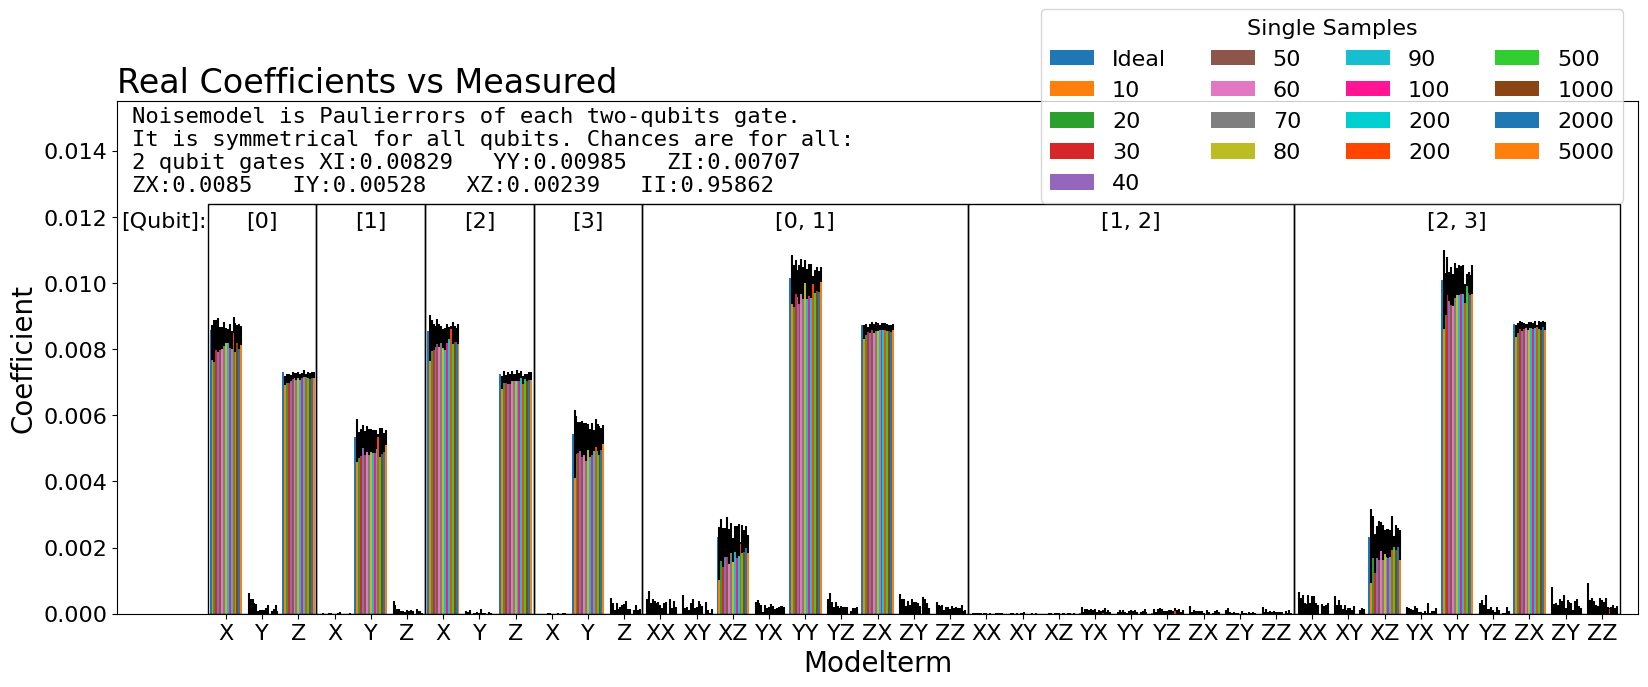

In [151]:
plot_data(True)

21


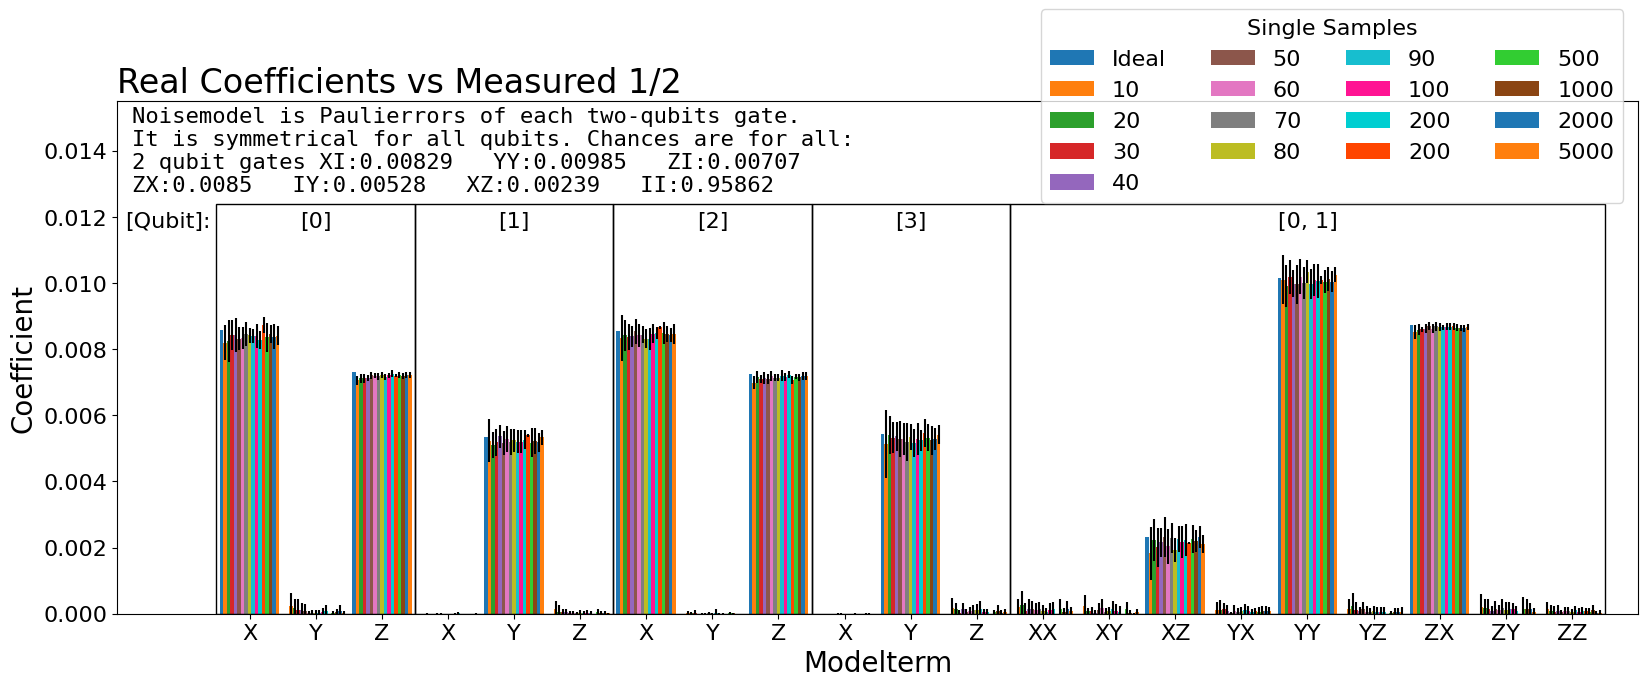

In [152]:
plot_data(True, dosplit=True, split=0)

21


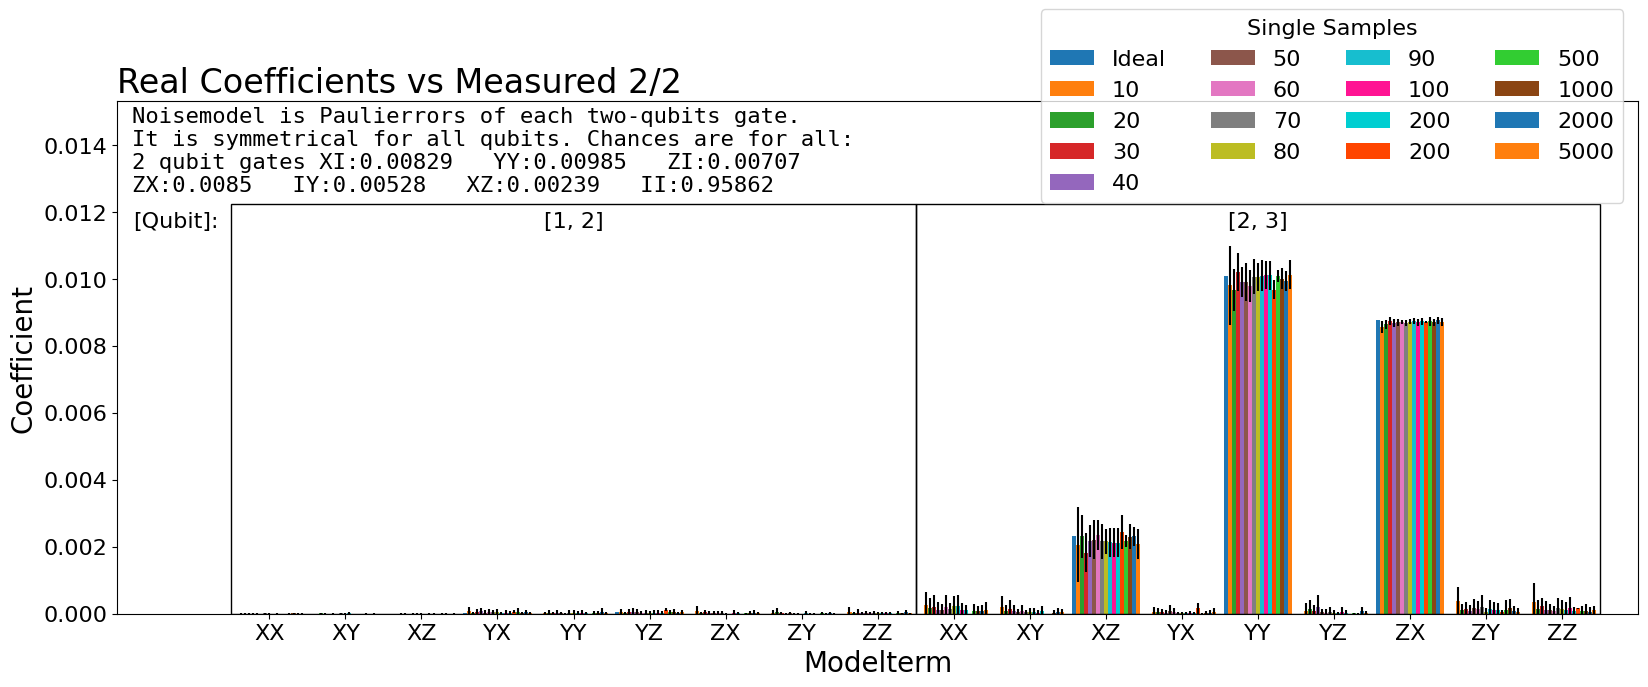

In [153]:
plot_data(True, dosplit=True, split=1)

e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\matplotlib\transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\numpy\ma\core.py:3448: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


39


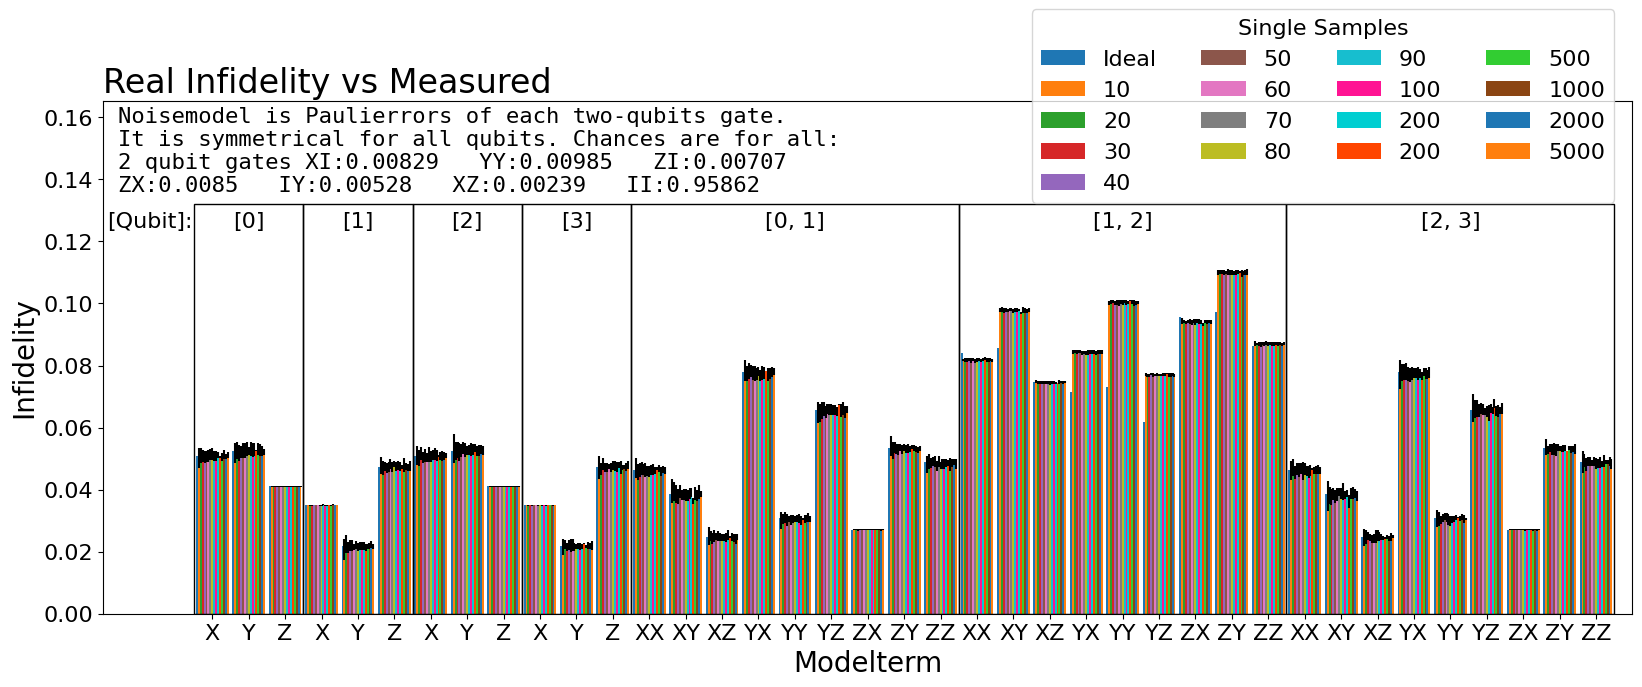

In [154]:
plot_data(False)

e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\matplotlib\transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\numpy\ma\core.py:3448: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


21


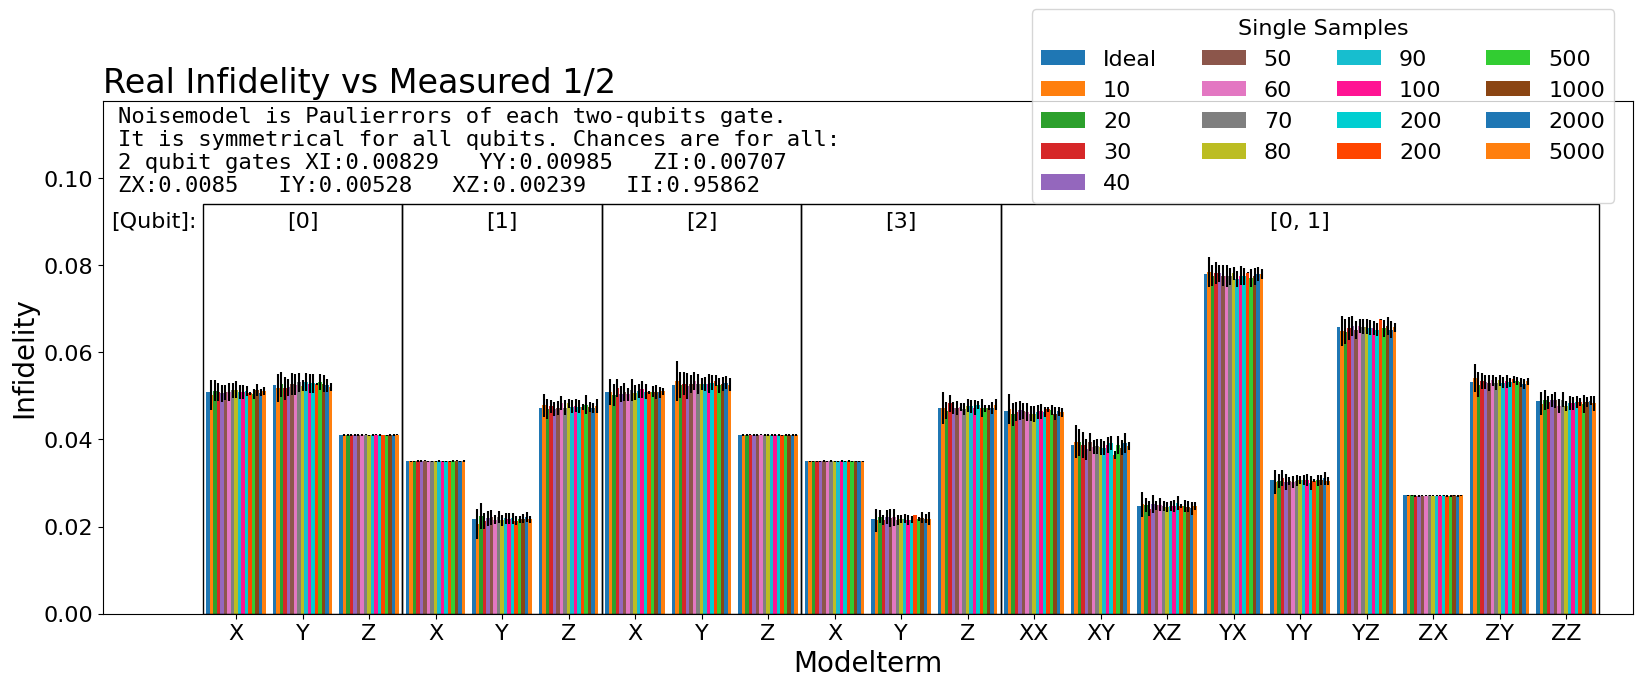

In [155]:
plot_data(False, dosplit=True, split=0)

e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\matplotlib\transforms.py:767: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)
e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\.venv2\lib\site-packages\numpy\ma\core.py:3448: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval


21


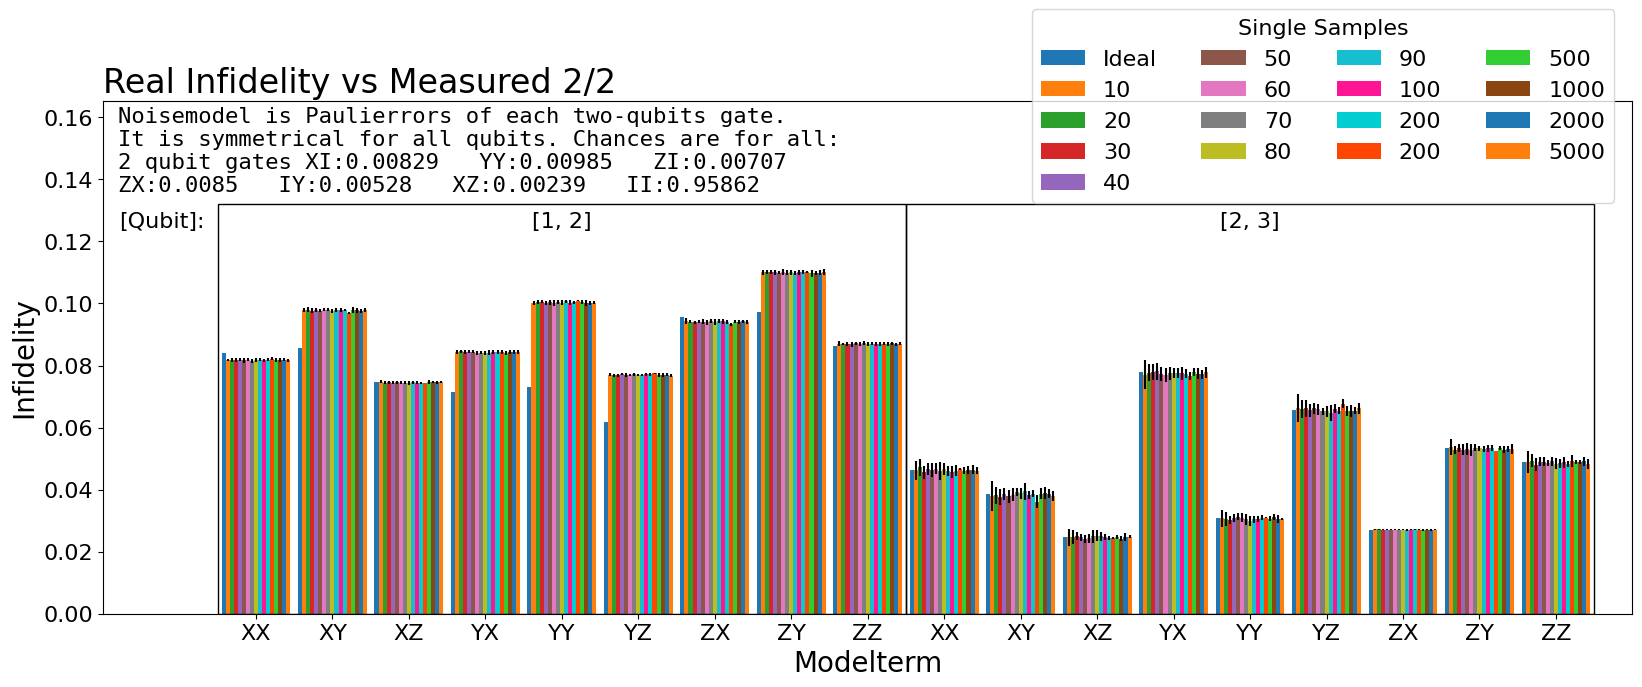

In [156]:
plot_data(False, dosplit=True, split=1)

In [157]:
coeffs_evaluation = []
coeffs_evaluation_err = []

for i in range(len(coeffs_datas)):
	eval_list = []
	for j in range(len(coeffs_datas[i])):
		for g in groups:
			eval_list += [abs(real_coeffs_dic_by_layer[j][g] - c) for c in coeffs_individual_datas[i][j][g]]
	eval = sum(eval_list)/len(eval_list)
	eval_err = np.std(eval_list)/len(eval_list)
	coeffs_evaluation.append(eval)
	coeffs_evaluation_err.append(eval_err)

In [158]:
infidelities_evaluation = []
infidelities_evaluation_err = []

for i in range(len(infidelities_datas)):
	eval_list = []
	for j in range(len(infidelities_datas[i])):
		for g in groups:
			eval_list += [abs(1-real_errors_by_layer[j][g].real - c) for c in infidelities_individual_datas[i][j][g]]
	eval = sum(eval_list)/len(eval_list)
	eval_err = np.std(eval_list)/len(eval_list)
	infidelities_evaluation.append(eval)
	infidelities_evaluation_err.append(eval_err)

0.0008200508757672301 -0.860174111411989 6.730769217683982e-05
0.004004832574168536 -0.6889591878643392 0.0027242510100830945


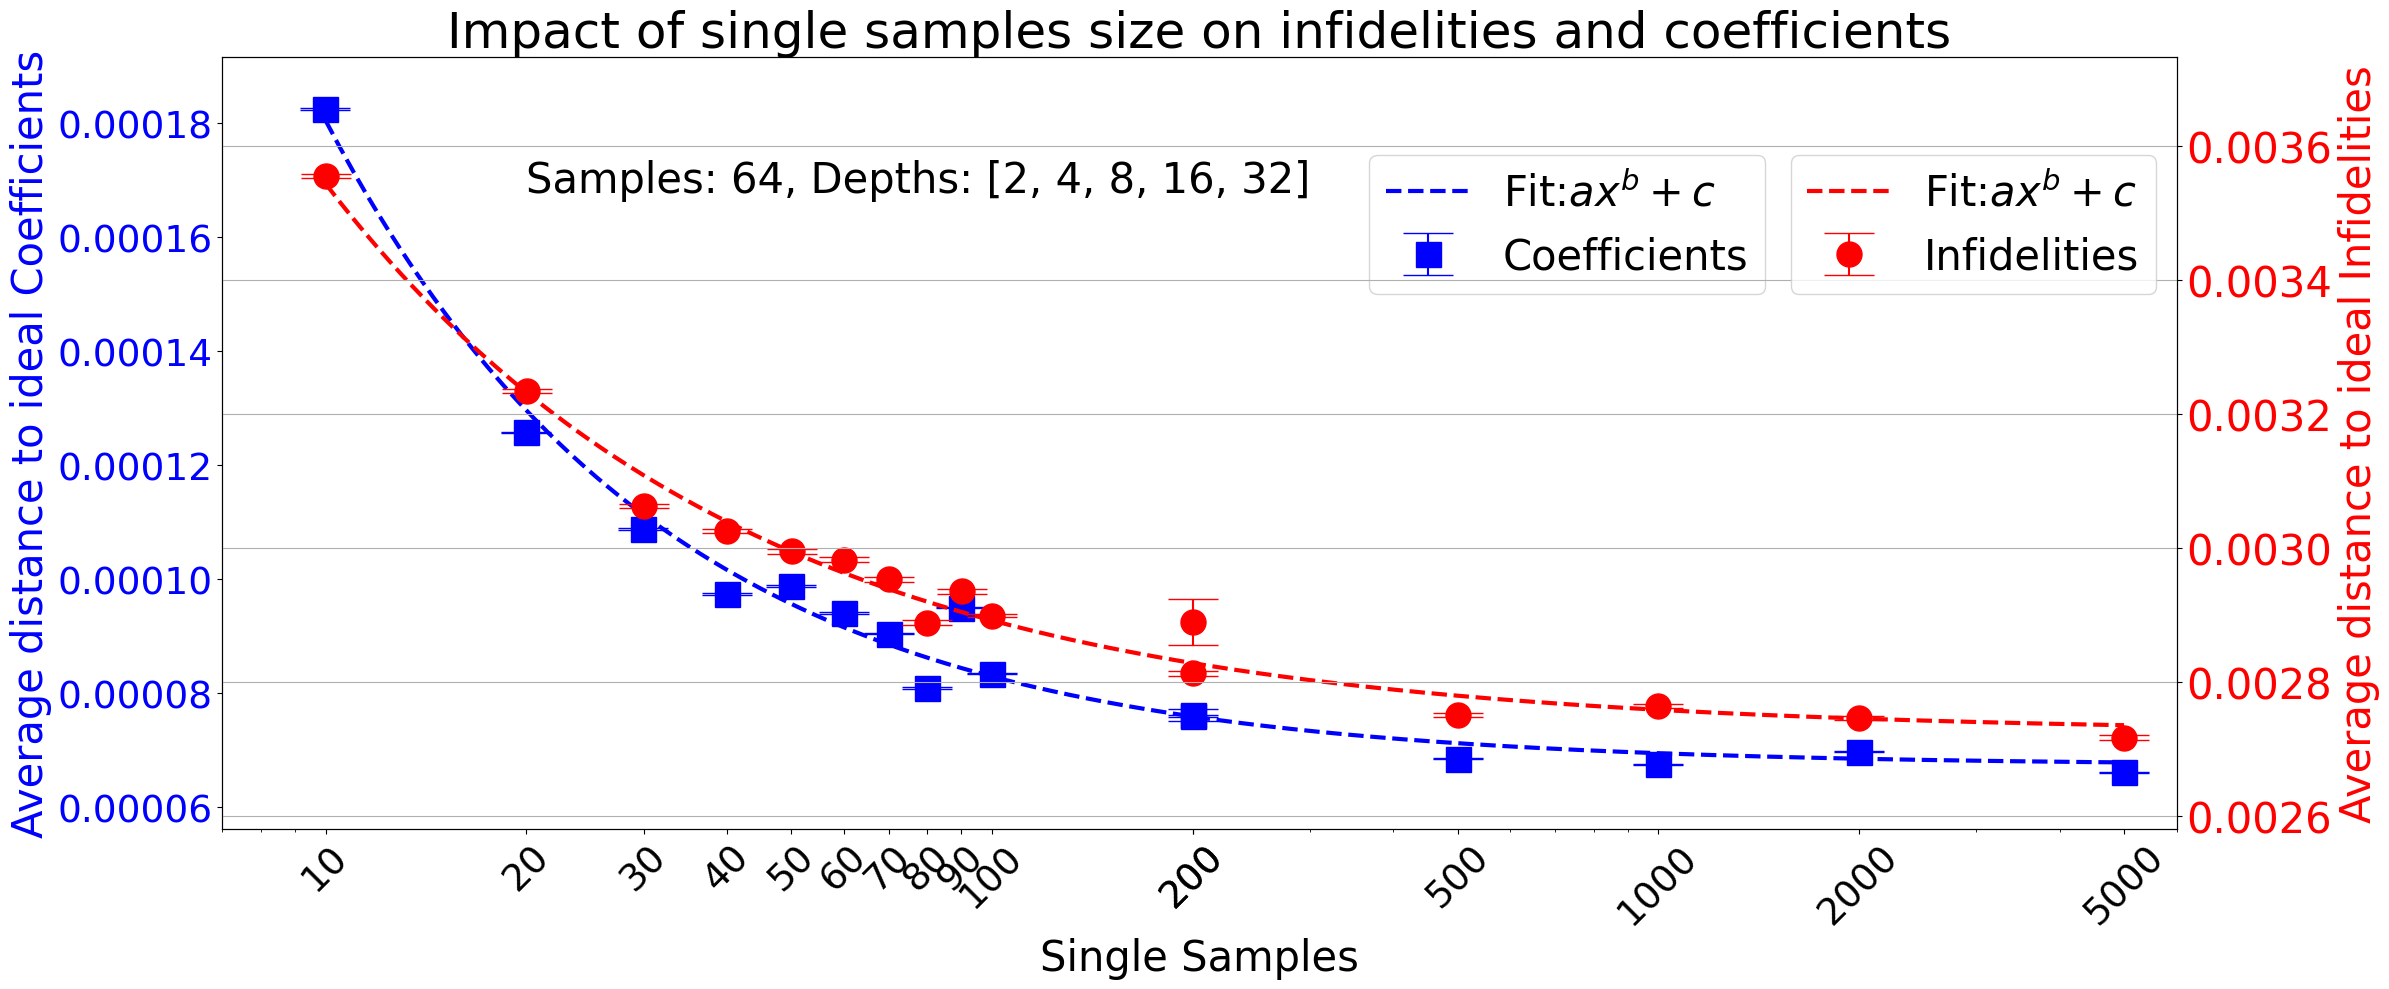

In [159]:
import matplotlib.pyplot as plt
fontsize=30
# X-Achse Werte für beide Datasets (Index jedes Punktes)
fig, ax1 = plt.subplots(figsize=(24, 10))
if pntsinglesamples != None or pntsamples != None:
	ax1.set_xscale('log')

if depth != None:
	x_values = [max(ast.literal_eval(i)) for i in labels[1:]]
	ax1.set_xticks([max(ast.literal_eval(i)) for i in labels[1:]])
	ax1.set_xlabel("Calculation Depths", fontsize=fontsize)
	ax1.text(32,max(coeffs_evaluation)*0.96, "Samples: " + str(decipher_name(filtered_folders[0])["pntsamples"]) + ", Single Samples: " + str(decipher_name(filtered_folders[0])["pntsinglesamples"]), fontsize=fontsize)
elif pntsamples != None:
	ax1.set_xlim(3,700)
	x_values = [int(i) for i in labels[1:]]
	ax1.set_xticks([int(i) for i in labels[1:]])#[i+1 for i in range(len(labels[1:]))])  # Nur an diesen Punkten Ticks setzen#[4,8,16,32,64,128])
	ax1.set_xlabel("Samples", fontsize=fontsize)
	ax1.text(30,max(coeffs_evaluation)*0.98, "Depths: " + str(decipher_name(filtered_folders[0])["depths"]) + ", Single Samples: " + str(decipher_name(filtered_folders[0])["pntsinglesamples"]), fontsize=fontsize)
elif pntsinglesamples != None:
	ax1.set_xlim(7,6000)
	x_values = [int(i) for i in labels[1:]]
	ax1.set_xticks([int(i) for i in labels[1:]])
	ax1.set_xlabel("Single Samples", fontsize=fontsize)
	
ax1.set_xticklabels(labels[1:], fontsize=fontsize, rotation=45)  # Ersetze durch gewünschte Bezeichnungen
#x_values = range(1, len(coeffs_evaluation) + 1)
xlin = np.linspace(min(x_values), max(x_values), max((max(x_values)-min(x_values))*2,100))

fitfunc = lambda x,a,b,c: a*np.pow(x,b)+c
popt, pcov = curve_fit(fitfunc, [val for val in x_values], coeffs_evaluation, p0 = [0.0006, -0.5, 0.00005])
a, b, c = popt
print(a,b,c)
ax1.plot(xlin, [a*np.pow(x,b)+c for x in xlin], color = 'b', linestyle="--", zorder=2,  label="Fit:$a x^b+c$ ", linewidth=2*fontsize/20)

# Plotten der Daten mit separaten Y-Achsen
text1 = "Coefficients"
#line1 = ax1.plot(x_values, coeffs_evaluation, marker='o', color='b', label='Coeffs')
line1 = ax1.errorbar([val-0.025 for val in x_values], coeffs_evaluation, yerr = coeffs_evaluation_err, capsize=12*fontsize/20, color='b', label=text1, fmt='s', zorder=2, markersize=12*fontsize/20)
ax1.set_ylabel("Average distance to ideal Coefficients", color='b', fontsize=fontsize)
ax1.tick_params(axis='y', labelcolor='b')

# Erstellen der zweiten Y-Achse für Dataset 2 auf der rechten Seite
ax2 = ax1.twinx()
popt, pcov = curve_fit(fitfunc, [val for val in x_values], infidelities_evaluation, p0 = [0.0006, -0.5, 0.00005])
a, b, c = popt
print(a,b,c)
ax2.plot(xlin, [a*np.pow(x,b)+c for x in xlin], color = 'r', linestyle="--",zorder=1, label="Fit:$a x^b+c$ ", linewidth=2*fontsize/20)
text2 = "Infidelities"
#line2 = ax2.plot(x_values, infidelities_evaluation, marker='o', color='r', label='Infidelities')
line2 = ax2.errorbar([val+0.025 for val in x_values], infidelities_evaluation, infidelities_evaluation_err, capsize=12*fontsize/20, color='r', label=text2, fmt='o', zorder=1, markersize=12*fontsize/20)
ax2.set_ylabel("Average distance to ideal Infidelities", color='r', fontsize=fontsize)
#ax2.yaxis.set_label_coords(1.09, 0.3)
#ax1.yaxis.set_label_coords(-0.03, 0.3)
ax2.tick_params(axis='y', labelcolor='r')

ax1.set_ylim(bottom=min(coeffs_evaluation)*0.85, top=max(coeffs_evaluation)*1.05)
ax2.set_ylim(bottom=min(infidelities_evaluation)*0.95, top=max(infidelities_evaluation)*1.05)


# Hinzufügen der Legende
#lines = line1 + line2
#labels = [text1, text2]
#ax1.legend(lines, labels, loc='upper left')
if pntsinglesamples != None and decipher_name(filtered_folders[0])["pntsamples"] == 64:
	ax1.legend(loc='upper right', fontsize=fontsize, bbox_to_anchor=(0.8, 0.90))
	ax2.legend(loc='upper right', fontsize=fontsize, bbox_to_anchor=(1.0, 0.90))
	ax1.text(20,max(coeffs_evaluation)*0.92, "Samples: " + str(decipher_name(filtered_folders[0])["pntsamples"]) + ", Depths: " + str(decipher_name(filtered_folders[0])["depths"]), fontsize=fontsize)
elif pntsinglesamples != None and decipher_name(filtered_folders[0])["pntsamples"] == 16: 
	ax1.legend(loc='upper right', fontsize=fontsize, bbox_to_anchor=(0.8, 0.93))
	ax2.legend(loc='upper right', fontsize=fontsize, bbox_to_anchor=(1.0, 0.93))
	ax1.text(20,max(coeffs_evaluation)*0.96, "Samples: " + str(decipher_name(filtered_folders[0])["pntsamples"]) + ", Depths: " + str(decipher_name(filtered_folders[0])["depths"]), fontsize=fontsize)
else:
	ax1.legend(loc='upper right', fontsize=fontsize, bbox_to_anchor=(0.8, 0.93))
	ax2.legend(loc='upper right', fontsize=fontsize, bbox_to_anchor=(1.0, 0.93))
titel = ""


# Titel und Raster
if depth != None:
	text = "depth"
elif pntsamples != None:
	text = "samples size"
elif pntsinglesamples!= None:
	text = "single samples size"
plt.title("Impact of " + text +  " on infidelities and coefficients", fontsize=fontsize*1.2)
ax1.tick_params(axis='both', which='major', labelsize=fontsize*0.9)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)
ax1.yaxis.get_offset_text().set_fontsize(fontsize)  # Adjust the size as needed
ax2.yaxis.get_offset_text().set_fontsize(fontsize)  # Adjust the size as needed

fig.tight_layout()
ax2.grid(True, zorder=0.5)

plt.show()


In [160]:
print(1-min(coeffs_evaluation)/max(coeffs_evaluation))

0.6376184493391599


In [161]:
for i in range(len(coeffs_evaluation)-1):
    print(coeffs_evaluation[i+1]/coeffs_evaluation[i])

0.6890126395891378
0.865383998554757
0.8950773671227154
1.014782629371404
0.9516442748657797
0.9615169325720063
0.8945127691239267
1.1742172583150736
0.8783693998554081
0.9106347185730873
1.003336717671781
0.898638734122552
0.9850801274133691
1.0333667611055541
0.9483105063126167
